## EXP 2 - Light GBM

### Import các thư viện cần thiết và tải lên các file dữ liệu 

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed để đảm bảo kết quả có thể tái lập
RANDOM_STATE = 42

In [4]:
train_exp2 = pd.read_csv('../../data/exp2/train_exp2.csv')
test_exp2 = pd.read_csv('../../data/exp2/test_exp2.csv')

In [5]:
# Lấy cột target (Class)
y_train = train_exp2['Class']

# Loại bỏ các cột không phải là feature
X_train = train_exp2.drop(['Class', 'Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')
X_test = test_exp2.drop(['Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (14396, 31)
y_train shape: (14396,)
X_test shape: (3600, 31)


### Tạo Dataset cho LightGBM

In [6]:
lgb_train = lgb.Dataset(X_train, y_train)

### Thiết lập tham số cho LightGBM

In [7]:
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(y_train.unique()),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': RANDOM_STATE
}

### Huấn luyện mô hình

In [8]:
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train],
    callbacks=[lgb.log_evaluation(50)]  # Hiển thị log mỗi 50 vòng
)

print("Huấn luyện mô hình hoàn tất!")

[50]	training's multi_logloss: 0.581655
[100]	training's multi_logloss: 0.382932
Huấn luyện mô hình hoàn tất!


### Đánh giá mô hình

In [9]:
# Dự đoán
y_train_pred_proba_lgb = lgb_model.predict(X_train)
y_train_pred_class_lgb = np.argmax(y_train_pred_proba_lgb, axis=1)

# Tính metrics
train_accuracy_lgb = accuracy_score(y_train, y_train_pred_class_lgb)
train_f1_lgb = f1_score(y_train, y_train_pred_class_lgb, average='weighted')
train_log_loss_lgb = log_loss(y_train, y_train_pred_proba_lgb)

# Cross-validation với sklearn interface
lgb_sklearn = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(y_train.unique()),
    learning_rate=0.1,
    n_estimators=100,
    random_state=RANDOM_STATE,
    verbose=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_f1_scores_lgb = cross_val_score(lgb_sklearn, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
cv_accuracy_scores_lgb = cross_val_score(lgb_sklearn, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Độ chính xác tập train: {train_accuracy_lgb:.4f}")
print(f"F1-Score tập train: {train_f1_lgb:.4f}")
print(f"Log Loss tập train: {train_log_loss_lgb:.4f}")
print(f"F1-Score CV: {cv_f1_scores_lgb.mean():.4f} (±{cv_f1_scores_lgb.std() * 2:.4f})")
print(f"Accuracy CV: {cv_accuracy_scores_lgb.mean():.4f} (±{cv_accuracy_scores_lgb.std() * 2:.4f})")

Độ chính xác tập train: 0.9080
F1-Score tập train: 0.9071
Log Loss tập train: 0.3829
F1-Score CV: 0.5983 (±0.0107)
Accuracy CV: 0.6066 (±0.0110)


### Phân tích các đặc trưng quan trọng

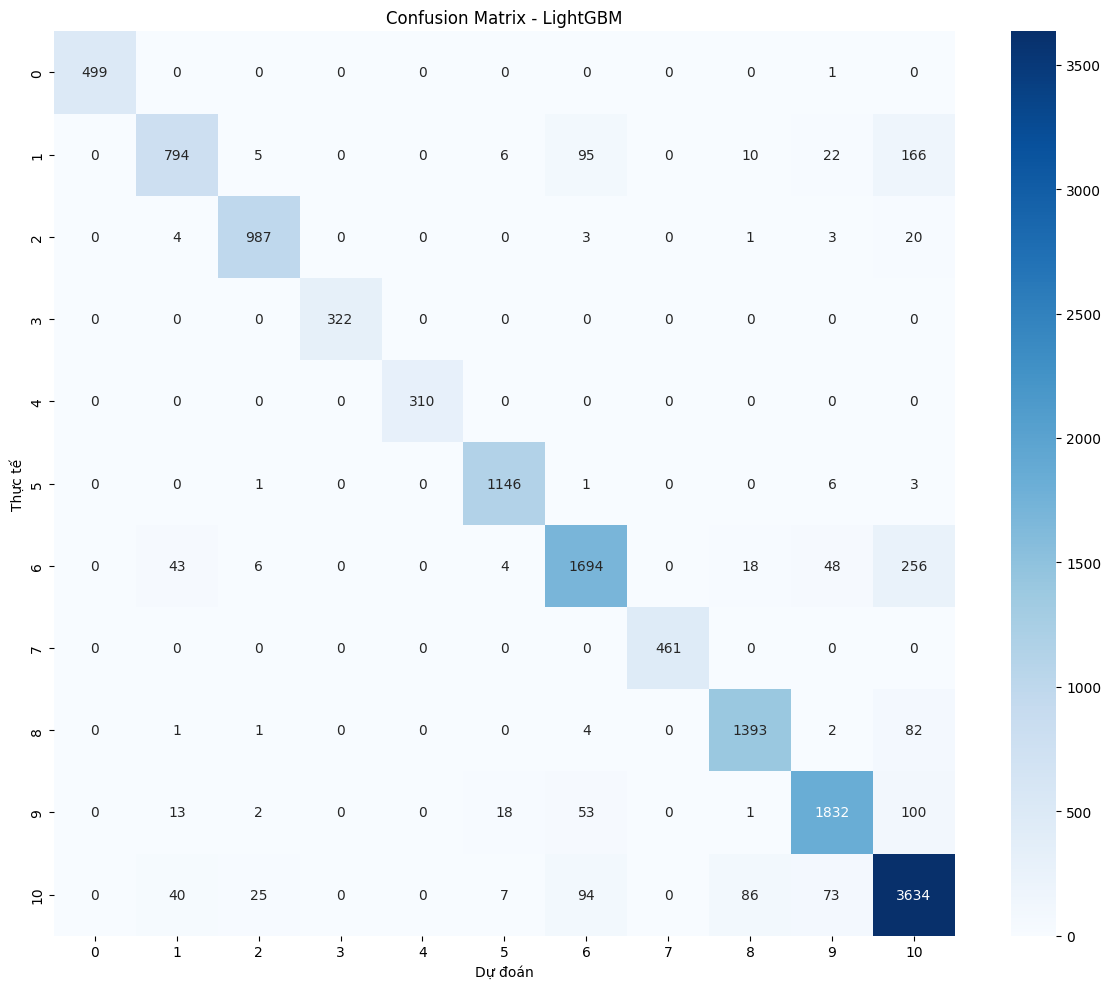

Độ chính xác theo từng class:
Class 0: 0.9980
Class 1: 0.7231
Class 2: 0.9695
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9905
Class 6: 0.8188
Class 7: 1.0000
Class 8: 0.9393
Class 9: 0.9074
Class 10: 0.9179
Các class cần cải thiện: []


In [11]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_train, y_train_pred_class_lgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_train), 
            yticklabels=np.unique(y_train))
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# Phân tích các class khó phân loại
class_report = classification_report(y_train, y_train_pred_class_lgb, output_dict=True)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("Độ chính xác theo từng class:")
for class_idx, acc in enumerate(class_accuracy):
    print(f"Class {class_idx}: {acc:.4f}")

# Tìm các class có độ chính xác thấp
low_accuracy_classes = [idx for idx, acc in enumerate(class_accuracy) if acc < 0.7]
print(f"Các class cần cải thiện: {low_accuracy_classes}")

### Lưu kết quả và file dự đoán

In [12]:
# Dự đoán trên tập test
test_predictions = lgb_model.predict(X_test)
print(f"Số lượng dự đoán: {len(test_predictions)}")

Số lượng dự đoán: 3600


In [ ]:
# Dự đoán trên tập test
test_proba = lgb_model.predict(X_test)
test_pred_labels = np.argmax(test_proba, axis=1)

# Tạo submission file
submission = pd.DataFrame({
    'Id': test_exp2['Id'],
    'Class': test_pred_labels
})

# Lưu file submission
submission_file_path_lr = 'results/LightGBM_submission.csv'
submission.to_csv(submission_file_path_lr, index=False)

print(f"File submission đã được lưu tại: {submission_file_path_lr}")
print(f"Kích thước file submission: {submission.shape}")

File submission đã được lưu tại: results/LightGBM_submission.csv
Kích thước file submission: (3600, 2)


### Tổng quan thông số

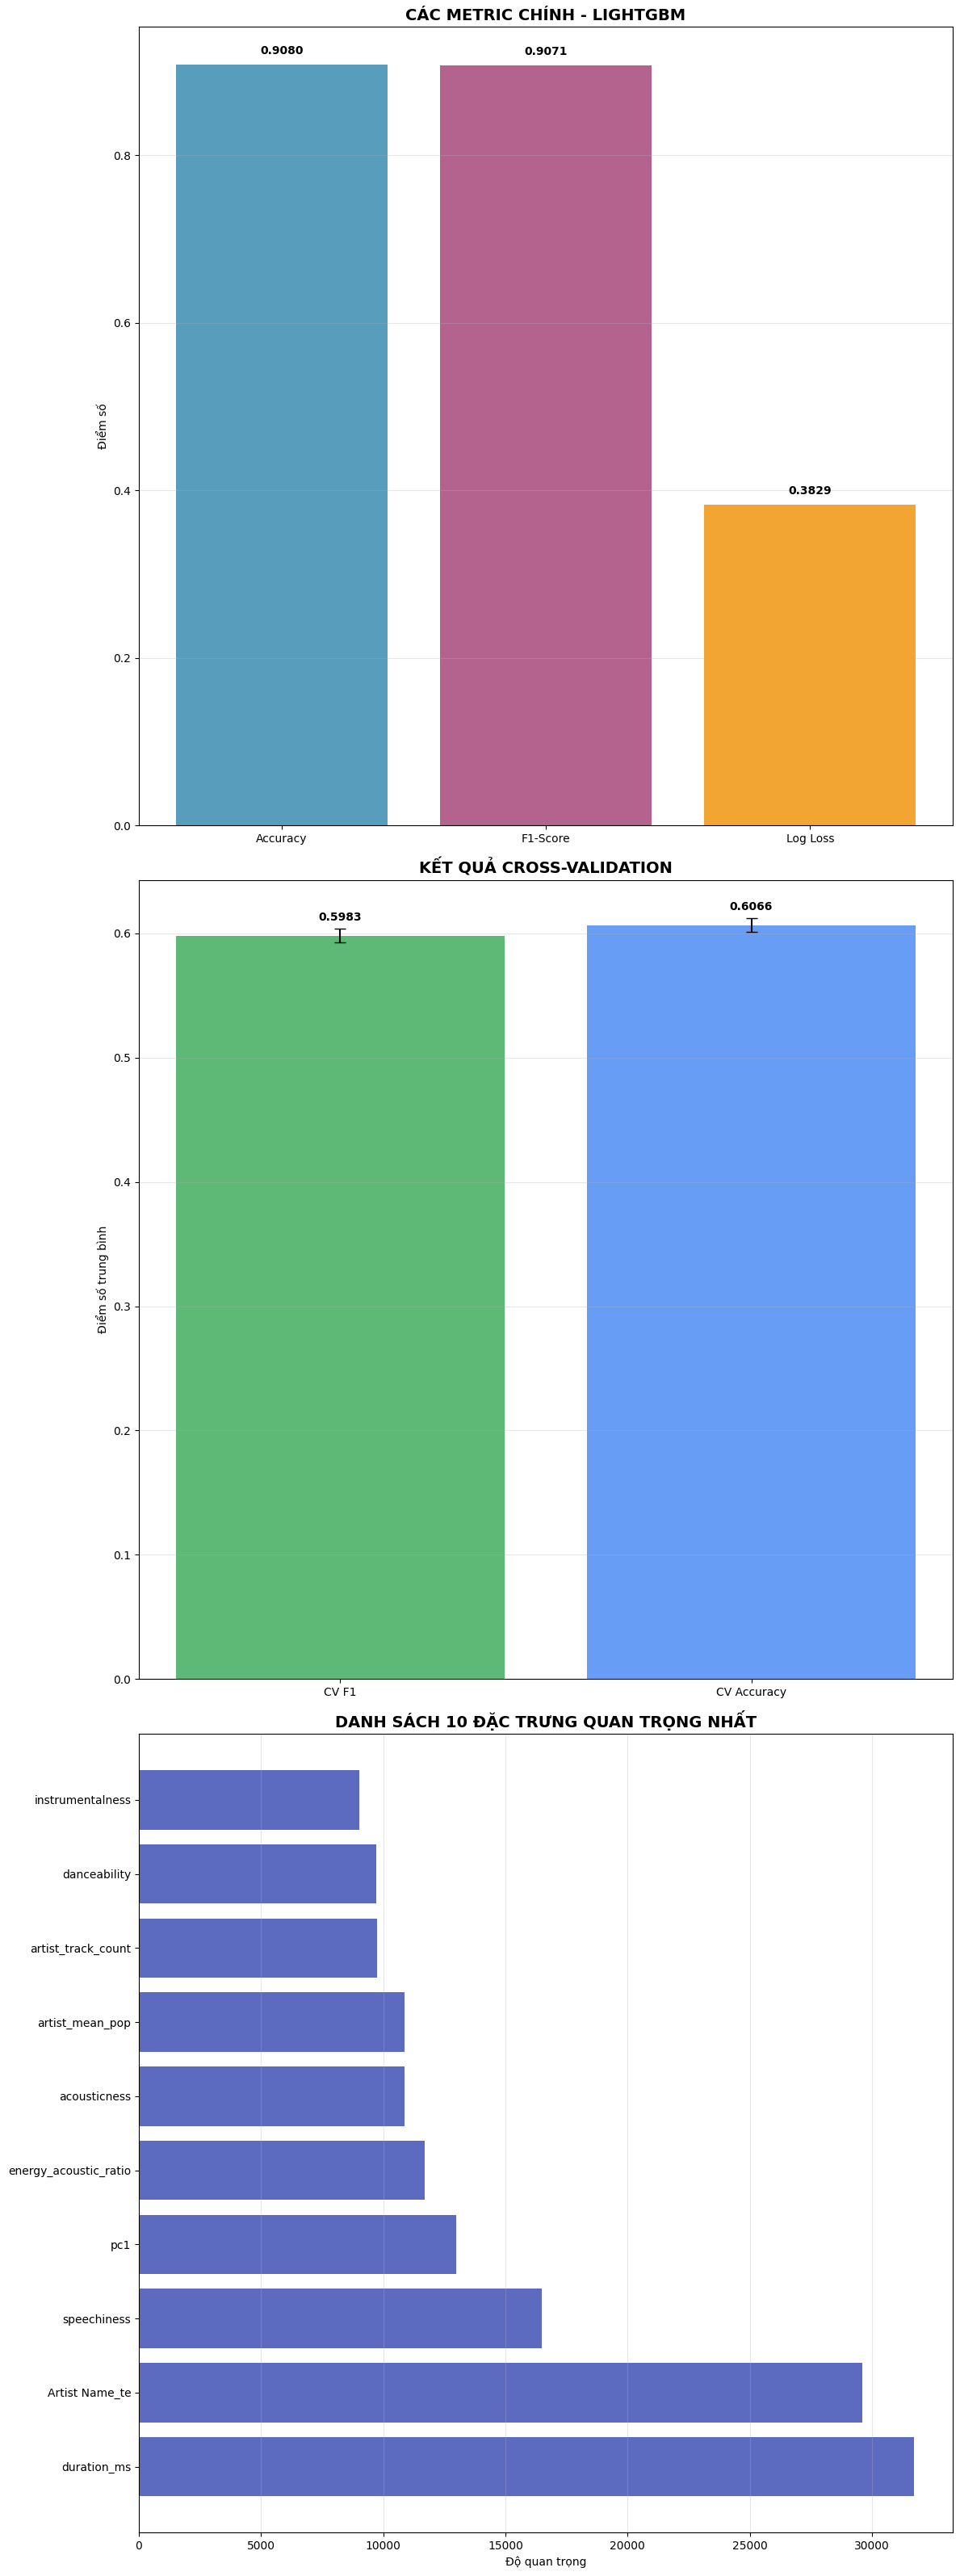

F1-Score LightGBM: 0.9071
F1-Score CV: 0.5983


In [16]:
fig, axes = plt.subplots(3, 1, figsize=(12, 32))

# 1. Biểu đồ metrics chính
metrics_lgb = ['Accuracy', 'F1-Score', 'Log Loss']
values_lgb = [train_accuracy_lgb, train_f1_lgb, train_log_loss_lgb]
colors_lgb = ['#2E86AB', '#A23B72', '#F18F01']

bars_lgb = axes[0].bar(metrics_lgb, values_lgb, color=colors_lgb, alpha=0.8)
axes[0].set_title('CÁC METRIC CHÍNH - LIGHTGBM', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Điểm số')
axes[0].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_lgb, values_lgb):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Biểu đồ cross-validation
cv_metrics_lgb = ['CV F1', 'CV Accuracy']
cv_means_lgb = [cv_f1_scores_lgb.mean(), cv_accuracy_scores_lgb.mean()]
cv_stds_lgb = [cv_f1_scores_lgb.std(), cv_accuracy_scores_lgb.std()]

bars_cv_lgb = axes[1].bar(cv_metrics_lgb, cv_means_lgb, yerr=cv_stds_lgb, capsize=5, 
                         color=['#34A853', '#4285F4'], alpha=0.8)
axes[1].set_title('KẾT QUẢ CROSS-VALIDATION', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Điểm số trung bình')
axes[1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_cv_lgb, cv_means_lgb):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Biểu đồ feature importance
feature_importance_lgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(10)

axes[2].barh(range(len(feature_importance_lgb)), feature_importance_lgb['importance'], color='#5C6BC0')
axes[2].set_yticks(range(len(feature_importance_lgb)))
axes[2].set_yticklabels(feature_importance_lgb['feature'])
axes[2].set_title('DANH SÁCH 10 ĐẶC TRƯNG QUAN TRỌNG NHẤT', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Độ quan trọng')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"F1-Score LightGBM: {train_f1_lgb:.4f}")
print(f"F1-Score CV: {cv_f1_scores_lgb.mean():.4f}")